In [ ]:
!pip install decord

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 99.1 MB/s eta 0:00:00


In [ ]:
from decord import VideoReader
from decord import cpu, gpu

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, Flatten
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from IPython.display import clear_output
import random

In [ ]:
from google.colab import drive
drive.mount("drive")

Mounted at drive


In [ ]:
!unzip drive/MyDrive/Criminal_Activity_Video_Surveillance_Dataset/Trimmed-Videos.zip -d Data/
clear_output()

In [ ]:
def load_video(path, max_frames=32, resize=(299, 224)):
    vr = VideoReader(path, ctx=cpu(0))
    start = 0
    end = int(max_frames*2)
    if end>len(vr):
      end = len(vr)
    frames_list = list(range(start, end, 2))
    frames_orig = vr.get_batch(frames_list).asnumpy()
    frames = []
    for f in frames_orig:
        frame = cv2.resize(f, resize)
        frames.append(frame)
    
    if len(frames) < max_frames:
        for i in range(max_frames-len(frames)):
            frames.append(np.zeros((resize[1], resize[0], 3)))
    if len(frames) > max_frames:
        frames = frames[:max_frames]
    
    return frames

In [ ]:
def build_feature_extractor(input_shape=(224, 299, 3)):
    feature_extractor = tf.keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=input_shape,
    )
    preprocess_input = tf.keras.applications.inception_v3.preprocess_input

    inputs = tf.keras.Input(input_shape)
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return tf.keras.Model(inputs, outputs, name="feature_extractor")

with tf.device('/GPU:0'):
    feature_extractor = build_feature_extractor()
feature_extractor.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 299, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
_________________________________

In [ ]:
normal_vids = os.listdir("Data/Trimmed-Videos/Normal")
random_vids = random.sample(normal_vids, 6000)
for f in random_vids:
    os.remove(f"Data/Trimmed-Videos/Normal/{f}")
del normal_vids, random_vids

In [ ]:
def prepare_videos(data_dir="Data", category=None, output_dir=None, batch_size=32, max_frames=32):
    cat = category
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    # for cat in os.listdir(data_dir):
    os.mkdir(f"{output_dir}/{cat}")
    all_vids = os.listdir(f"{data_dir}/{cat}")
    n_vids = len(all_vids)
    # print(f"Processing {cat} videos:")
    for idx in tqdm(range(n_vids//batch_size)):
        index = idx * batch_size
        batch_vids = all_vids[index:(index+batch_size)]
        encodings = []
        frames = []
        
        for v in batch_vids:
            frames.extend(load_video(f"{data_dir}/{cat}/{v}", max_frames=max_frames))
        encodings = feature_extractor.predict(np.array(frames), verbose=0).astype(np.float32)

        batch_encodings = []
        for i in range(batch_size):
            start_idx = i*max_frames
            batch_encodings.append(encodings[start_idx:(start_idx+max_frames)])
        batch_encodings = np.array(batch_encodings, dtype=np.float32)
        np.save(f"{output_dir}/{cat}/{cat}_batch_{idx}.npy", batch_encodings)
    del batch_encodings, encodings, frames, all_vids     # To save space (RAM)
            

In [ ]:
prepare_videos(data_dir="Data/Trimmed-Videos", category="Abuse", output_dir="Data/Encoded-Videos")

100%|██████████| 27/27 [02:29<00:00,  5.52s/it]


In [ ]:
prepare_videos(data_dir="Data/Trimmed-Videos", category="Arson", output_dir="Data/Encoded-Videos")

100%|██████████| 35/35 [02:55<00:00,  5.02s/it]


In [ ]:
prepare_videos(data_dir="Data/Trimmed-Videos", category="Assault", output_dir="Data/Encoded-Videos")

100%|██████████| 24/24 [02:07<00:00,  5.33s/it]


In [ ]:
prepare_videos(data_dir="Data/Trimmed-Videos", category="Burglary", output_dir="Data/Encoded-Videos")

100%|██████████| 178/178 [14:35<00:00,  4.92s/it]


In [ ]:
prepare_videos(data_dir="Data/Trimmed-Videos", category="Explosion", output_dir="Data/Encoded-Videos")

100%|██████████| 45/45 [03:43<00:00,  4.97s/it]


In [ ]:
prepare_videos(data_dir="Data/Trimmed-Videos", category="Normal", output_dir="Data/Encoded-Videos")

 47%|████▋     | 148/312 [12:14<13:41,  5.01s/it]

In [ ]:
# prepare_videos(data_dir="Data/Trimmed-Videos", category="Normal", output_dir="Data/Encoded-Videos")

100%|██████████| 164/164 [14:54<00:00,  5.46s/it]


In [ ]:
prepare_videos(data_dir="Data/Trimmed-Videos", category="Fighting", output_dir="Data/Encoded-Videos")

100%|██████████| 62/62 [06:11<00:00,  5.99s/it]


In [ ]:
prepare_videos(data_dir="Data/Trimmed-Videos", category="Shooting", output_dir="Data/Encoded-Videos")

100%|██████████| 21/21 [01:39<00:00,  4.74s/it]


In [ ]:
prepare_videos(data_dir="Data/Trimmed-Videos", category="RoadAccidents", output_dir="Data/Encoded-Videos")

100%|██████████| 18/18 [01:26<00:00,  4.80s/it]


In [ ]:
prepare_videos(data_dir="Data/Trimmed-Videos", category="Robbery", output_dir="Data/Encoded-Videos")

100%|██████████| 107/107 [08:52<00:00,  4.98s/it]


In [ ]:
!rm -r Data/Trimmed-Videos/Abuse
!rm -r Data/Trimmed-Videos/Arson
!rm -r Data/Trimmed-Videos/Assault
!rm -r Data/Trimmed-Videos/Burglary
!rm -r Data/Trimmed-Videos/Explosion
!rm -r Data/Trimmed-Videos/Normal
!rm -r Data/Trimmed-Videos/Fighting
!rm -r Data/Trimmed-Videos/Shooting
!rm -r Data/Trimmed-Videos/RoadAccidents
!rm -r Data/Trimmed-Videos/Robbery

### Splitting batches into individual feature embeddings for randomization.

In [ ]:
# !unzip drive/MyDrive/Criminal_Activity_Video_Surveillance_Dataset/Encoded-Videos-batched.zip -d Data/
# clear_output()

In [ ]:
if not os.path.exists("Data/Encoded-Videos-individual"):
    os.mkdir("Data/Encoded-Videos-individual")

In [ ]:
for cat in os.listdir("Data/Encoded-Videos"):
    os.mkdir(f"Data/Encoded-Videos-individual/{cat}")
    print(f"Processing {cat} files:")
    for b in tqdm(os.listdir(f"Data/Encoded-Videos/{cat}")):
        batch = np.load(f"Data/Encoded-Videos/{cat}/{b}")
        for i,v in enumerate(batch):
            np.save(f"Data/Encoded-Videos-individual/{cat}/{b.replace('.npy', '')}_{i}.npy", v)
        del batch

Processing RoadAccidents files:


100%|██████████| 18/18 [00:01<00:00,  9.22it/s]


Processing Normal files:


100%|██████████| 312/312 [00:34<00:00,  9.05it/s]


Processing Robbery files:


100%|██████████| 107/107 [00:09<00:00, 11.87it/s]


Processing Shooting files:


100%|██████████| 21/21 [00:01<00:00, 11.61it/s]


Processing Assault files:


100%|██████████| 24/24 [00:01<00:00, 12.52it/s]


Processing Burglary files:


100%|██████████| 178/178 [00:16<00:00, 11.12it/s]


Processing Fighting files:


100%|██████████| 62/62 [00:04<00:00, 12.95it/s]


Processing Arson files:


100%|██████████| 35/35 [00:03<00:00, 11.13it/s]


Processing Explosion files:


100%|██████████| 45/45 [00:05<00:00,  7.92it/s]


Processing Abuse files:


100%|██████████| 27/27 [00:03<00:00,  8.50it/s]


In [ ]:
from glob import glob
files = glob("Data/Encoded-Videos-individual/*/*.npy")
len(files)

26528

In [ ]:
# !zip -r Encoded-Videos-individual.zip Data/Encoded-Videos-individual
# clear_output()

In [ ]:
# !cp Encoded-Videos-individual.zip drive/MyDrive/Criminal_Activity_Video_Surveillance_Dataset/

### Creating dataframe of filenames and their labels

In [ ]:
!unzip /content/drive/MyDrive/Criminal_Activity_Video_Surveillance_Dataset/Encoded-Videos-individual.zip
clear_output()

In [ ]:
rooms = []
for item in os.listdir('Data/Encoded-Videos-individual'):
     files = os.listdir(f'Data/Encoded-Videos-individual/{item}')

     # Add them to the list
     for file in files:
            rooms.append((item, f'Data/Encoded-Videos-individual/{item}/{file}'))
    
# Build a dataframe        
df = pd.DataFrame(data=rooms, columns=['label', 'filepath'])
df_final = df.sample(frac = 1)
df_final = df_final.reset_index(drop=True)

TEST_SIZE = 5000
test_df = df_final.iloc[:TEST_SIZE].reset_index(drop=True)
train_df = df_final.iloc[TEST_SIZE:].reset_index(drop=True)

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 21528
Total videos for testing: 5000


,label,filepath
17568,Normal,Data/Encoded-Videos-individual/Normal/Normal_b...
1294,Abuse,Data/Encoded-Videos-individual/Abuse/Abuse_bat...
19212,Normal,Data/Encoded-Videos-individual/Normal/Normal_b...
4167,Fighting,Data/Encoded-Videos-individual/Fighting/Fighti...
12329,Explosion,Data/Encoded-Videos-individual/Explosion/Explo...
19351,Burglary,Data/Encoded-Videos-individual/Burglary/Burgla...
7389,Explosion,Data/Encoded-Videos-individual/Explosion/Explo...
5250,Normal,Data/Encoded-Videos-individual/Normal/Normal_b...
4731,Normal,Data/Encoded-Videos-individual/Normal/Normal_b...
14898,Normal,Data/Encoded-Videos-individual/Normal/Normal_b...


In [ ]:
test_df.to_csv("Data/test_df.csv", index=False)
train_df.to_csv("Data/train_df.csv", index=False)

!cp Data/test_df.csv drive/MyDrive/Criminal_Activity_Video_Surveillance_Dataset/
!cp Data/train_df.csv drive/MyDrive/Criminal_Activity_Video_Surveillance_Dataset/

In [ ]:
# train_df = pd.read_csv("drive/MyDrive/Criminal_Activity_Video_Surveillance_Dataset/train_df.csv")
# test_df = pd.read_csv("drive/MyDrive/Criminal_Activity_Video_Surveillance_Dataset/test_df.csv")

### Label Encoding
StringLookup layer encode the class labels as integers.

In [ ]:
label_processor = tf.keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df["label"]), output_mode='one_hot')
print(label_processor.get_vocabulary())

labels = train_df["label"].values
labels = label_processor(labels[..., None]).numpy()
labels

['Abuse', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'Normal', 'RoadAccidents', 'Robbery', 'Shooting']


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
# class DataGenerator(tf.keras.utils.Sequence):
#     def __init__(self, df, x_col='filepath', y_col='label', batch_size=32, num_classes=None, shuffle=True):
#         self.batch_size = batch_size
#         self.df = df
#         self.indices = self.df.index.tolist()
#         self.num_classes = num_classes
#         self.shuffle = shuffle
#         self.x_col = x_col
#         self.y_col = y_col
#         self.on_epoch_end()

#     def __len__(self):
#         return len(self.indices) // self.batch_size

#     def __getitem__(self, index):
#         index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
#         batch = [self.indices[k] for k in index]
        
#         X, y = self.__get_data(batch)
#         return X, y

#     def on_epoch_end(self):
#         self.index = np.arange(len(self.indices))
#         if self.shuffle == True:
#             np.random.shuffle(self.index)

#     def __load_video(self, path, max_frames=32, resize=(299, 224)):
#         cap = cv2.VideoCapture(path)
#         frames = []
#         try:
#             counter = 0
#             while True:
#                 ret, frame = cap.read()
#                 if not ret:
#                     break
#                 frame = cv2.resize(frame, resize)
#                 frame = frame[:, :, [2, 1, 0]]
#                 if counter%2==0:
#                     frames.append(frame)

#                 if len(frames) == max_frames:
#                     break
#         finally:
#             cap.release()
        
#         if len(frames) < max_frames:
#             for i in range(max_frames-len(frames)):
#                 frames.append(np.zeros((resize[1], resize[0], 3)))
#         if len(frames) > max_frames:
#             frames = frames[:max_frames]
        
#         return np.array(frames)

#     def __get_data(self, batch):
        
#         batch_df = self.df.iloc[batch]
#         labels = batch_df[self.y_col].values
#         y = label_processor(labels[..., None]).numpy()

#         imgs_encodings = []
#         for ig in batch_df[self.x_col].values:
#             frames = self.__load_video(ig)
#             encodings = feature_extractor.predict(frames).astype(np.float32)
#             imgs_encodings.append(encodings)
        
#         X = np.array(imgs_encodings)

#         return X, y

In [ ]:
# class DataGenerator(tf.keras.utils.Sequence):
#     def __init__(self, df, x_col='filepath', y_col='label', batch_size=32, num_classes=None, shuffle=True):
#         self.batch_size = batch_size
#         self.df = df
#         self.indices = self.df.index.tolist()
#         self.num_classes = num_classes
#         self.shuffle = shuffle
#         self.x_col = x_col
#         self.y_col = y_col
#         self.on_epoch_end()

#     def __len__(self):
#         return len(self.indices) // self.batch_size

#     def __getitem__(self, index):
#         index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
#         batch = [self.indices[k] for k in index]
        
#         X, y = self.__get_data(batch)
#         return X, y

#     def on_epoch_end(self):
#         self.index = np.arange(len(self.indices))
#         if self.shuffle == True:
#             np.random.shuffle(self.index)

#     def __load_video(self, path, max_frames=32, resize=(299, 224)):
#         vr = VideoReader(path, ctx=cpu(0))
#         start = 0
#         end = int(max_frames*2)
#         if end>len(vr):
#           end = len(vr)
#         frames_list = list(range(start, end, 2))
#         frames_orig = vr.get_batch(frames_list).asnumpy()
#         frames = []
#         for f in frames_orig:
#             frame = cv2.resize(f, resize)
#             frames.append(frame)
        
#         if len(frames) < max_frames:
#             for i in range(max_frames-len(frames)):
#                 frames.append(np.zeros((resize[1], resize[0], 3)))
#         if len(frames) > max_frames:
#             frames = frames[:max_frames]
        
#         return np.array(frames)

#     def __get_data(self, batch):
        
#         batch_df = self.df.iloc[batch]
#         labels = batch_df[self.y_col].values
#         y = label_processor(labels[..., None]).numpy()

#         imgs_encodings = []
#         for ig in batch_df[self.x_col].values:
#             frames = self.__load_video(ig)
#             encodings = feature_extractor.predict(frames).astype(np.float32)
#             imgs_encodings.append(encodings)
        
#         X = np.array(imgs_encodings)

#         return X, y

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, x_col='filepath', y_col='label', batch_size=32, num_classes=None, shuffle=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.x_col = x_col
        self.y_col = y_col
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    # def __load_video(self, path, max_frames=32, resize=(299, 224)):
    #     vr = VideoReader(path, ctx=cpu(0))
    #     start = 0
    #     end = int(max_frames*2)
    #     if end>len(vr):
    #       end = len(vr)
    #     frames_list = list(range(start, end, 2))
    #     frames_orig = vr.get_batch(frames_list).asnumpy()
    #     frames = []
    #     for f in frames_orig:
    #         frame = cv2.resize(f, resize)
    #         frames.append(frame)
        
    #     if len(frames) < max_frames:
    #         for i in range(max_frames-len(frames)):
    #             frames.append(np.zeros((resize[1], resize[0], 3)))
    #     if len(frames) > max_frames:
    #         frames = frames[:max_frames]
        
    #     return np.array(frames)

    def __get_data(self, batch):
        
        batch_df = self.df.iloc[batch]
        labels = batch_df[self.y_col].values
        y = label_processor(labels[..., None]).numpy()

        imgs_encodings = []
        for ig in batch_df[self.x_col].values:
            # frames = self.__load_video(ig)
            # encodings = feature_extractor.predict(frames).astype(np.float32)
            encodings = np.load(ig)
            imgs_encodings.append(encodings)
        
        X = np.array(imgs_encodings)

        return X, y

In [ ]:
#Define hyperparameters

IMG_SIZE = (299, 224)
BATCH_SIZE = 32
EPOCHS = 100

MAX_SEQ_LENGTH = 32
NUM_FEATURES = 2048

In [ ]:
train_gen = DataGenerator(df=train_df, x_col='filepath', y_col='label', batch_size=BATCH_SIZE)
val_gen = DataGenerator(df=test_df, x_col='filepath', y_col='label', batch_size=BATCH_SIZE)

In [ ]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = tf.keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    # mask_input = tf.keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = tf.keras.layers.LSTM(256, return_sequences=True)(frame_features_input)
    x = tf.keras.layers.LSTM(128)(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(32, activation="relu")(x)
    output = tf.keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = tf.keras.Model(frame_features_input, output)

    rnn_model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

In [ ]:
with tf.device('/GPU:0'):
    seq_model = get_sequence_model()
seq_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 2048)]        0         
                                                                 
 lstm (LSTM)                 (None, 32, 256)           2360320   
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 2,561,898
Trainable params: 2,561,898
Non-train

In [ ]:
os.mkdir("Output")

In [ ]:
weight_path="Output2/checkpoint-{epoch:03d}-{val_accuracy:.3f}.hdf5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=8)

CALLBACKS = [checkpoint, early]

In [ ]:
history = seq_model.fit(train_gen,
                        validation_data=val_gen,
                        epochs=EPOCHS,
                        callbacks=CALLBACKS)

Epoch 1/100
672/672 [==============================] - ETA: 0s - loss: 1.4151 - accuracy: 0.5253
Epoch 1: val_loss improved from inf to 1.09438, saving model to Output/checkpoint-001-0.643.hdf5
672/672 [==============================] - 95s 134ms/step - loss: 1.4151 - accuracy: 0.5253 - val_loss: 1.0944 - val_accuracy: 0.6434
Epoch 2/100
672/672 [==============================] - ETA: 0s - loss: 1.0103 - accuracy: 0.6642
Epoch 2: val_loss improved from 1.09438 to 0.92880, saving model to Output/checkpoint-002-0.681.hdf5
672/672 [==============================] - 90s 134ms/step - loss: 1.0103 - accuracy: 0.6642 - val_loss: 0.9288 - val_accuracy: 0.6807
Epoch 3/100
672/672 [==============================] - ETA: 0s - loss: 0.8454 - accuracy: 0.7191
Epoch 3: val_loss improved from 0.92880 to 0.75777, saving model to Output/checkpoint-003-0.746.hdf5
672/672 [==============================] - 92s 137ms/step - loss: 0.8454 - accuracy: 0.7191 - val_loss: 0.7578 - val_accuracy: 0.7458
Epoch 4/

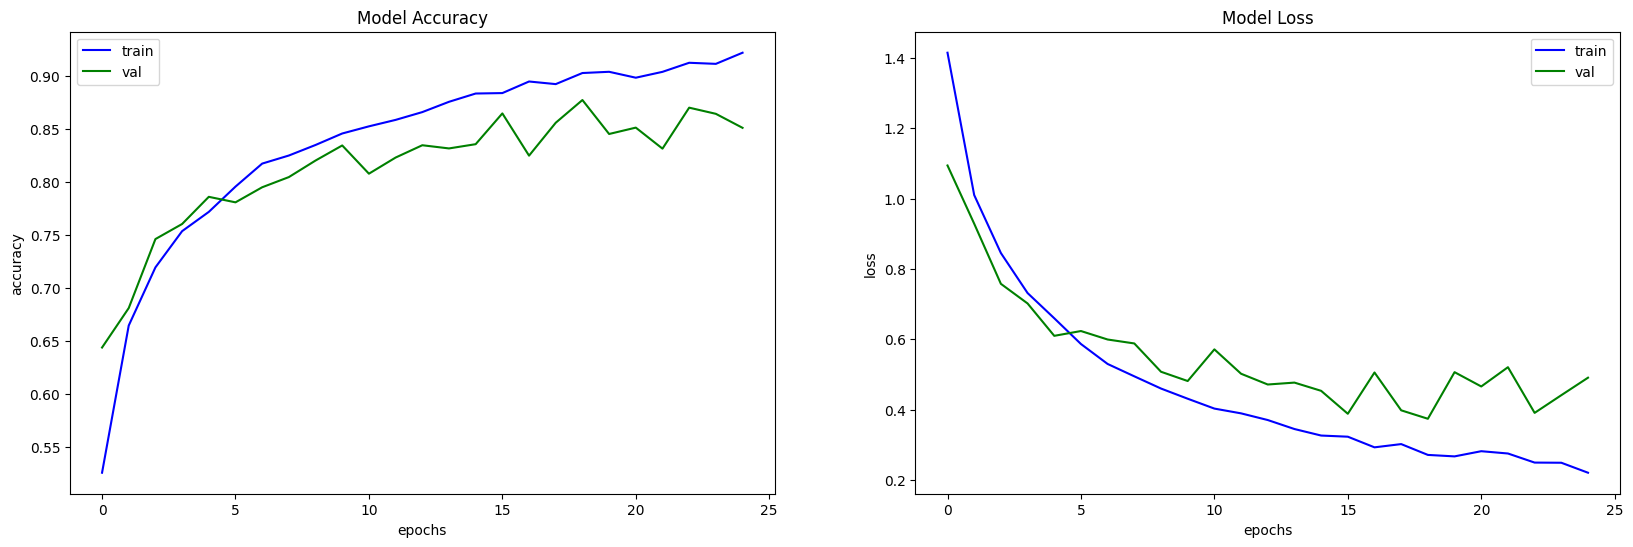

In [ ]:
plt.figure(figsize=(20,6))
for i, met in enumerate(['accuracy', 'loss']):
    plt.subplot(1,2,i+1)
    plt.plot(history.history[met], color="b")
    plt.plot(history.history["val_"+met], color="g")
    plt.title('Model '+met.capitalize())
    plt.xlabel('epochs')
    plt.ylabel(met)
    plt.legend(['train', 'val'])

In [ ]:
import pickle
with open('seq_model_trainHistory', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
# To load history
# history = pickle.load(open('seq_model_trainHistory', "rb"))

In [ ]:
!zip -r trained_models.zip Output
clear_output()

In [ ]:
!cp seq_model_trainHistory /content/drive/MyDrive/Criminal_Activity_Video_Surveillance_Dataset/
!cp trained_models.zip /content/drive/MyDrive/Criminal_Activity_Video_Surveillance_Dataset/

In [ ]:
os.mkdir("Output2")

In [ ]:
history2 = seq_model.fit(train_gen,
                        validation_data=val_gen,
                        epochs=20,
                        callbacks=CALLBACKS)

Epoch 1/20
672/672 [==============================] - ETA: 0s - loss: 0.2271 - accuracy: 0.9182
Epoch 1: val_loss improved from inf to 0.41007, saving model to Output2/checkpoint-001-0.875.hdf5
672/672 [==============================] - 99s 148ms/step - loss: 0.2271 - accuracy: 0.9182 - val_loss: 0.4101 - val_accuracy: 0.8752
Epoch 2/20
672/672 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.9223
Epoch 2: val_loss improved from 0.41007 to 0.39140, saving model to Output2/checkpoint-002-0.882.hdf5
672/672 [==============================] - 89s 132ms/step - loss: 0.2120 - accuracy: 0.9223 - val_loss: 0.3914 - val_accuracy: 0.8820
Epoch 3/20
672/672 [==============================] - ETA: 0s - loss: 0.2129 - accuracy: 0.9229
Epoch 3: val_loss did not improve from 0.39140
672/672 [==============================] - 91s 135ms/step - loss: 0.2129 - accuracy: 0.9229 - val_loss: 0.4036 - val_accuracy: 0.8706
Epoch 4/20
672/672 [==============================] - ETA: 0s -

In [ ]:
import pickle
with open('seq_model_trainHistory2', 'wb') as file_pi:
        pickle.dump(history2.history, file_pi)
# To load history
# history = pickle.load(open('seq_model_trainHistory2', "rb"))

In [ ]:
!zip -r trained_models2.zip Output2
clear_output()

In [ ]:
!cp seq_model_trainHistory2 /content/drive/MyDrive/Criminal_Activity_Video_Surveillance_Dataset/
!cp trained_models2.zip /content/drive/MyDrive/Criminal_Activity_Video_Surveillance_Dataset/

In [ ]:
loss = []
val_loss = []
accuracy = []
val_accuracy = []

loss.extend(history.history['loss'])
loss.extend(history2.history['loss'])

val_loss.extend(history.history['val_loss'])
val_loss.extend(history2.history['val_loss'])

accuracy.extend(history.history['accuracy'])
accuracy.extend(history2.history['accuracy'])

val_accuracy.extend(history.history['val_accuracy'])
val_accuracy.extend(history2.history['val_accuracy'])

overall_history = {}
overall_history['loss'] = loss
overall_history['val_loss'] = val_loss
overall_history['accuracy'] = accuracy
overall_history['val_accuracy'] = val_accuracy

In [ ]:
len(overall_history['val_accuracy'])

40

36

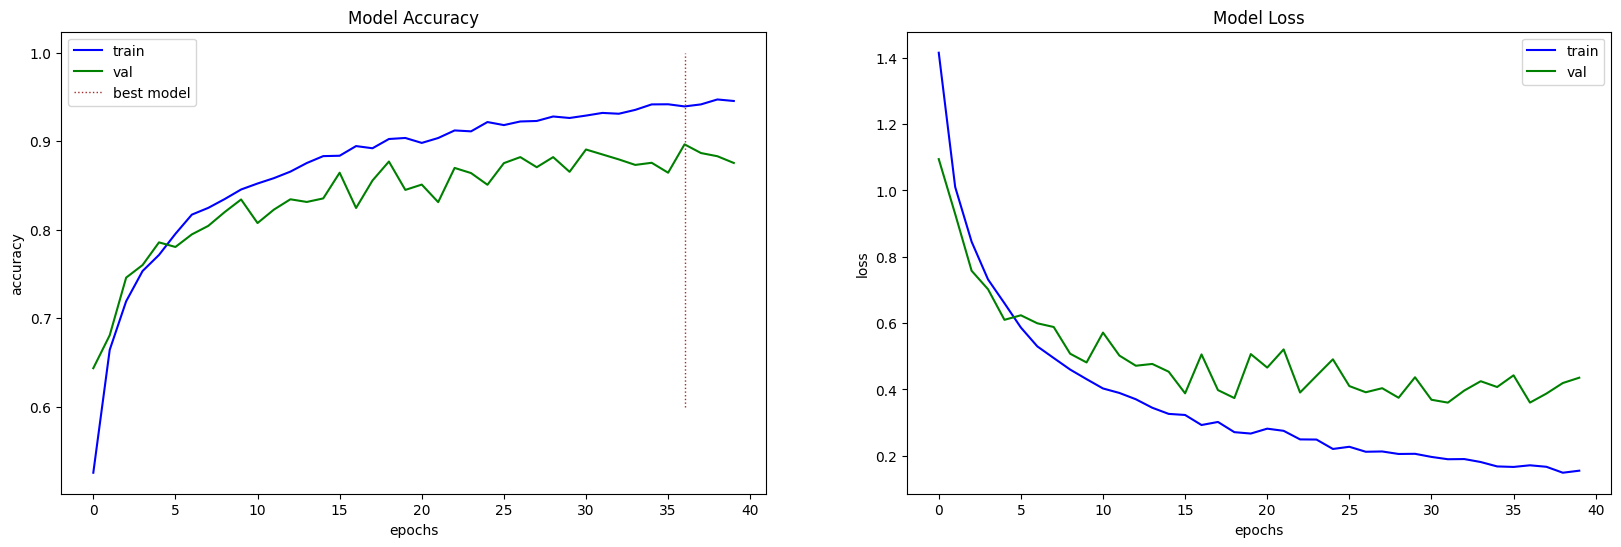

In [ ]:
plt.figure(figsize=(20,6))
for i, met in enumerate(['accuracy', 'loss']):
    plt.subplot(1,2,i+1)
    plt.plot(overall_history[met], color="b")
    plt.plot(overall_history["val_"+met], color="g")
    if met=='accuracy':
        plt.vlines(x=np.argmax(overall_history['val_accuracy']), ymin=0.6, ymax=1, colors='brown', ls=':', lw=1, label='best model')
    plt.title('Model '+met.capitalize())
    plt.xlabel('epochs')
    plt.ylabel(met)
    if met=='accuracy':
        plt.legend(['train', 'val', 'best model'])
    else:
        plt.legend(['train', 'val'])

In [ ]:
import pickle
with open('overall_seq_model_trainHistory', 'wb') as file_pi:
    pickle.dump(overall_history, file_pi)
# To load history
# history = pickle.load(open('overall_seq_model_trainHistory', "rb"))

In [ ]:
!cp overall_seq_model_trainHistory /content/drive/MyDrive/Criminal_Activity_Video_Surveillance_Dataset/

In [ ]:
# Saving Best Model in drive

In [ ]:
# feature_extractor.save("feature_extractor_inceptionv3.h5")

In [ ]:
# !cp feature_extractor_inceptionv3.h5 drive/MyDrive/Criminal_Activity_Video_Surveillance_Dataset/Models/

In [ ]:
!unzip drive/MyDrive/Criminal_Activity_Video_Surveillance_Dataset/trained_models.zip

Archive:  drive/MyDrive/Criminal_Activity_Video_Surveillance_Dataset/trained_models.zip
   creating: Output/
  inflating: Output/checkpoint-015-0.835.hdf5  
  inflating: Output/checkpoint-013-0.834.hdf5  
  inflating: Output/checkpoint-008-0.804.hdf5  
  inflating: Output/checkpoint-004-0.760.hdf5  
  inflating: Output/checkpoint-005-0.786.hdf5  
  inflating: Output/checkpoint-009-0.820.hdf5  
  inflating: Output/checkpoint-002-0.681.hdf5  
  inflating: Output/checkpoint-001-0.643.hdf5  
  inflating: Output/checkpoint-003-0.746.hdf5  
  inflating: Output/checkpoint-016-0.864.hdf5  
  inflating: Output/checkpoint-010-0.834.hdf5  
  inflating: Output/checkpoint-019-0.877.hdf5  
  inflating: Output/checkpoint-007-0.795.hdf5  


In [ ]:
with tf.device('/GPU:0'):
    seq_model = get_sequence_model()
    seq_model.load_weights("/content/Output/checkpoint-019-0.877.hdf5")
seq_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 2048)]        0         
                                                                 
 lstm_2 (LSTM)               (None, 32, 256)           2360320   
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 2,561,898
Trainable params: 2,561,898
Non-tra

In [ ]:
# seq_model.save("classifier_lstm_e19.h5")

In [ ]:
# !cp classifier_lstm_e19.h5 drive/MyDrive/Criminal_Activity_Video_Surveillance_Dataset/Models/